In [1]:
import collections
import os
import ROOT
import array
import copy
import prettytable
import math
import matplotlib.pyplot as plt
import numpy as np
import itertools
import IPython

Welcome to JupyROOT 6.24/06


In [2]:
plt.rcParams['hatch.linewidth'] = 2
HATCHES = [ '//', '\\\\', 'xx', '++', 'OO', 'oo', '..', '**' ]

adjust_xsec = True

INT_LUMI = 1.4e5  # 140 fb; 1e3 -> fb, 1e-3 -> nb, 1 -> pb
XSEC_NNLO = 61526.7

WJETS_INCLUSIVE = [{
  'input': 'wjets.root',
  'xsec': 5.416e+04,
  'stat': int(3e6),
  'is_inc': True,
  'is_ht': False,
  'label': 'Inclusive',
  'name' : 'Inclusive',
}]
WJETS_NJET = [
  {
    'input': 'w1jets.root',
    'xsec': 8.919e+03,
    'stat': int(4.9e6),
    'is_inc': False,
    'is_ht': False,
    'label': r'$N_{\mathrm{jet}} = 1$',
    'name' : 'Njet = 1',
  },
  {
    'input': 'w2jets.root',
    'xsec': 2.829e+03,
    'stat': int(1.6e6),
    'is_inc': False,
    'is_ht': False,
    'label': r'$N_{\mathrm{jet}} = 2$',
    'name' : 'Njet = 2',
  },
  {
    'input': 'w3jets.root',
    'xsec': 8.255e+02,
    'stat': int(4.6e5),
    'is_inc': False,
    'is_ht': False,
    'label': r'$N_{\mathrm{jet}} = 3$',
    'name' : 'Njet = 3',
  },
  {
    'input': 'w4jets.root',
    'xsec': 3.901e+02,
    'stat': int(2.2e5),
    'is_inc': False,
    'is_ht': False,
    'label': r'$N_{\mathrm{jet}} = 4$',
    'name' : 'Njet = 4',
  },
]
WJETS_HT = [
  {
    'input': 'wjets_ht70to100.root',
    'xsec': 1.255e+03,
    'stat': int(7e5),
    'is_inc': False,
    'is_ht': True,
    'label': '70 < $H_T$ < 100 GeV',
    'name' : '70 < HT < 100',
  },
  {
    'input': 'wjets_ht100to200.root',
    'xsec': 1.243e+03,
    'stat': int(6.9e5),
    'is_inc': False,
    'is_ht': True,
    'label': '100 < $H_T$ < 200 GeV',
    'name' : '100 < HT < 200',
  },
  {
    'input': 'wjets_ht200to400.root',
    'xsec': 3.339e+02,
    'stat': int(1.9e5),
    'is_inc': False,
    'is_ht': True,
    'label': '200 < $H_T$ < 400 GeV',
    'name': '200 < HT < 400',
  },
  {
    'input': 'wjets_ht400to600.root',
    'xsec': 4.516e+01,
    'stat': int(2.6e4),
    'is_inc': False,
    'is_ht': True,
    'label': '400 < $H_T$ < 600 GeV',
    'name': '400 < HT < 600',
  },
  {
    'input': 'wjets_ht600to800.root',
    'xsec': 1.112e+01,
    'stat': int(6.2e3),
    'is_inc': False,
    'is_ht': True,
    'label': '600 < $H_T$ < 800 GeV',
    'name': '600 < HT < 800',
  },
  {
    'input': 'wjets_ht800to1200.root',
    'xsec': 5.527e+00 * (0.85 if adjust_xsec else 1),
    'stat': int(3.1e3),
    'is_inc': False,
    'is_ht': True,
    'label': '800 < $H_T$ < 1200 GeV',
    'name': '800 < HT < 1200',
  },
  {
    'input': 'wjets_ht1200to2500.root',
    'xsec': 1.850e+00 * (0.72 if adjust_xsec else 1),
    'stat': int(1.1e3),
    'is_inc': False,
    'is_ht': True,
    'label': '1200 < $H_T$ < 2500 GeV',
    'name': '1200 < HT < 2500',
  },
  {
    'input': 'wjets_ht2500toInf.root',
    'xsec': 4.594e-02,
    'stat': int(2.5e1),
    'is_inc': False,
    'is_ht': True,
    'label': '$H_T$ > 2500 GeV',
    'name': '1HT > 2500',
  }
]

k_factor = XSEC_NNLO / WJETS_INCLUSIVE[0]['xsec']
for wjet_sample in WJETS_INCLUSIVE:
  wjet_sample['xsec'] *= k_factor
for wjet_sample in WJETS_NJET:
  wjet_sample['xsec'] *= k_factor
for wjet_sample in WJETS_HT:
  wjet_sample['xsec'] *= k_factor

INPUT_SAMPLES = {
  'WJets': WJETS_INCLUSIVE + WJETS_NJET + WJETS_HT,
  'WJets_Njet': WJETS_INCLUSIVE + WJETS_NJET,
}

INPUT_VARS = {
  'WJets': collections.OrderedDict([
    ('LHE_Njets', [0, 1, 2, 3, 4, 5]),
    ('LHE_HT', [0, 70, 100, 200, 400, 600, 800, 1200, 2500, 13000, int(1e5)]),
  ]),
  'WJets_Njet': collections.OrderedDict([
    ('LHE_Njets', [0, 1, 2, 3, 4, 5]),
  ]),
}

def stitch(choice, input_dir, use_least_squares):
  output_dir = choice
  plotdir = os.path.join(output_dir, 'plots')
  histogram_dir = os.path.join(output_dir, 'histograms')

  assert(choice in INPUT_SAMPLES)
  assert(choice in INPUT_VARS)

  assert(input_dir != histogram_dir)

  if not os.path.isdir(histogram_dir):
    os.makedirs(histogram_dir)
  if not os.path.isdir(plotdir):
    os.makedirs(plotdir)

  input_var_keys_choice = INPUT_VARS[choice]
  input_var_keys = list(input_var_keys_choice.keys())

  def find_bin_idx(bin_content, bin_array, max_limit = False):
    bin_content_mod = bin_content
    if max_limit:
      bin_content_mod = min(bin_content, bin_array[-2])
    else:
      assert(bin_array[0] <= bin_content_mod < bin_array[-1])
    for bin_idx in range(len(bin_array) - 1):
      if bin_array[bin_idx] <= bin_content_mod < bin_array[bin_idx + 1]:
        return bin_idx
    assert(False)

  binning = collections.OrderedDict()
  if choice == 'WJets_Njet':
    binning['njet'] = list(range(13))
    binning['lead'] = list(range(20, 400, 20))
    binning['sublead'] = list(range(20, 400, 20))
    binning['ht'] = list(range(0, 2000, 100))
  elif choice == 'WJets':
    binning['njet'] = list(range(13))
    binning['lead'] = list(range(20, 400, 20))
    binning['sublead'] = list(range(20, 400, 20))
    binning['ht'] = list(range(0, 3000, 200))
  else:
    assert(False)

  def get_input_var_arr(input_var_key_name):
    assert(input_var_key_name in input_var_keys)
    assert(input_var_key_name in input_var_keys_choice)
    input_var_key_bins = input_var_keys_choice[input_var_key_name]
    return [
      '{}_{}to{}'.format(input_var_key_name, input_var_key_bins[i], input_var_key_bins[i + 1])
      for i in range(len(input_var_key_bins) - 1)
    ]

  def get_merged_var_elem(idxs):
    assert(len(idxs) == len(input_var_keys))
    return '_vs_'.join(get_input_var_arr(input_var_keys[i])[idxs[i]] for i in range(len(idxs)))

  ps_names = [ get_input_var_arr(input_var_keys[i]) for i in range(len(input_var_keys)) ]
  ps_merged = [ '_vs_'.join(list(x)) for x in list(itertools.product(*ps_names)) ]

  EV_KEY = 'EventCount'
  EV_SIGNS = [ '', 'pos', 'neg' ]

  def cleanup(obj_name):
    obj = ROOT.gROOT.FindObject(obj_name)
    if obj:
      obj.Delete()
      del obj

  def print_table(t):
    IPython.display.display(IPython.core.display.HTML(t.get_html_string()))

  def extract(input_fn, max_events, MAX_NGENJET = 32, use_avg = True):
    input_basename = os.path.basename(input_fn).replace('.root', '')
    histograms = collections.OrderedDict()
    binning_keys = list(binning.keys()) + [EV_KEY]
    for bin_name in binning_keys:
      for ps_name in ps_merged:
        for sign in EV_SIGNS:
          hname = '{}_{}'.format(bin_name, ps_name)
          if sign:
            hname += '_{}'.format(sign)
          hname_uniq = '{}_{}'.format(input_basename, hname)
          cleanup(hname_uniq)
          if bin_name != EV_KEY:
            histograms[hname] = ROOT.TH1F(
              hname_uniq, hname, len(binning[bin_name]) - 1, array.array('f', binning[bin_name])
            )
          else:
            histograms[hname] = ROOT.TH1F(hname_uniq, hname, 1, -0.5, +0.5)
          histograms[hname].Sumw2()
    for sign in EV_SIGNS:
      hname = EV_KEY
      if sign:
        hname += '_{}'.format(sign)
      hname_uniq = '{}_{}'.format(input_basename, hname)
      cleanup(hname_uniq)
      histograms[hname] = ROOT.TH1F(hname_uniq, hname, 1, -0.5, +0.5)

    assert(os.path.isfile(input_fn))
    input_fptr = ROOT.TFile.Open(input_fn, 'read')
    input_tree = input_fptr.Get('Events')

    genWeight = array.array('f', [0.])
    ngenjet = array.array('I', [0])
    genjet_leadPt = array.array('f', [0.] * MAX_NGENJET)
    genjet_subleadPt = array.array('f', [0.] * MAX_NGENJET)
    ht_scalar = array.array('f', [0.] * MAX_NGENJET)

    input_var_brs = collections.OrderedDict()
    for input_var_key in input_var_keys:
      if input_var_key == 'LHE_HT':
        input_var_brs[input_var_key] = array.array('f', [0.])
      else:
        input_var_brs[input_var_key] = array.array('I', [0])
      input_tree.SetBranchAddress(input_var_key, input_var_brs[input_var_key])
    input_tree.SetBranchAddress('genWeight', genWeight)
    input_tree.SetBranchAddress('nGenJet', ngenjet)
    input_tree.SetBranchAddress('GenJet_leadPt', genjet_leadPt)
    input_tree.SetBranchAddress('GenJet_subLeadPt', genjet_subleadPt)
    input_tree.SetBranchAddress('GenJet_HT_scalar', ht_scalar)
    input_tree.SetBranchStatus('*', 0)
    input_tree.SetBranchStatus('genWeight', 1)
    input_tree.SetBranchStatus('nGenJet', 1)
    input_tree.SetBranchStatus('GenJet_leadPt', 1)
    input_tree.SetBranchStatus('GenJet_subLeadPt', 1)
    input_tree.SetBranchStatus('GenJet_HT_scalar', 1)
    for input_var_key in input_var_brs:
      input_tree.SetBranchStatus(input_var_key, 1)

    # determine event statistics first
    unique_weights = {}
    if use_avg:
      for i in range(max_events):
        input_tree.GetEntry(i)
        gw_cur = genWeight[0]
        if gw_cur not in unique_weights:
          unique_weights[gw_cur] = 0
        unique_weights[gw_cur] += 1
      event_sum = sum([ k * v for k, v in unique_weights.items() ])
      event_count = sum([ v for v in unique_weights.values() ])
      avg_weigth = event_sum / event_count
    else:
      avg_weigth = 1

    for i in range(max_events):
      input_tree.GetEntry(i)

      gw_cur = genWeight[0] / avg_weigth
      if gw_cur not in unique_weights:
        unique_weights[gw_cur] = 0
      unique_weights[gw_cur] += 1
      gw_sign = 'pos' if gw_cur > 0. else 'neg'
      gw_signs = [ '', gw_sign ]

      bin_idxs = [
        find_bin_idx(input_var_brs[input_var_key][0], input_var_keys_choice[input_var_key]) \
        for input_var_key in input_var_brs
      ]
      bin_name = get_merged_var_elem(bin_idxs)

      to_fill = collections.OrderedDict([
        ('njet', ngenjet[0]),
        ('lead', genjet_leadPt[0]),
        ('sublead', genjet_subleadPt[0]),
        ('ht', ht_scalar[0]),
        (EV_KEY, 0),
      ])
      for varname in to_fill:
        assert(varname in binning_keys)
        for sign in gw_signs:
          hname = '{}_{}'.format(varname, bin_name)
          if sign:
            hname += '_{}'.format(sign)
          assert(hname in histograms)
          histograms[hname].Fill(to_fill[varname], gw_cur)
      for sign in gw_signs:
        hname = EV_KEY
        if sign:
          hname += '_{}'.format(sign)
        histograms[hname].Fill(0, gw_cur)
    input_fptr.Close()

    event_sum = sum([ k * v for k, v in unique_weights.items() ])
    if not use_avg:
      for hname in histograms:
        histograms[hname].Scale(1. / event_sum)

    output_fn = os.path.join(histogram_dir, os.path.basename(input_fn))
    output_fptr = ROOT.TFile.Open(output_fn, 'recreate')
    output_fptr.cd()
    for hname in histograms:
      histograms[hname].Write()
    output_fptr.Close()

    return histograms

  input_samples = copy.deepcopy(INPUT_SAMPLES[choice])
  for sample in input_samples:
    sample['histograms'] = extract(os.path.join(input_dir, sample['input']), sample['stat'])

  def fmt_cell(val):
    if val in [ 0, 1]:
      return '{:.0f}'.format(val)
    elif int(np.ceil(np.log10(val))) > -1:
      return '{:.3f}'.format(val)
    else:
      return '{:.2e}'.format(val)

  sample_table = prettytable.PrettyTable(['Sample name', 'Number of events', 'Cross section [pb]'])
  for sample_details in input_samples:
    sample_table.add_row([
      sample_details['name'],
      '{:.3e}'.format(sample_details['histograms'][EV_KEY].Integral()),
      '{:.3e}'.format(sample_details['xsec']),
    ])
  print_table(sample_table)

  if len(input_var_keys) == 1:
    nof_cols = len(input_samples)
    xsec_header = ['Sample name'] + [ 'P{}'.format(pidx) for pidx in range(nof_cols) ]
    xsec_table = prettytable.PrettyTable(xsec_header)
    for sample_details in input_samples:
      xsec_row = [ sample_details['name'] ]
      if sample_details['is_inc']:
        xsec_inc = sample_details['xsec']
        first_col = 1. - sum(
          input_samples[sample_idx]['xsec'] / xsec_inc \
          for sample_idx in range(1, len(input_samples))
        )
        xsec_row.append(fmt_cell(first_col))
        for sample_idx in range(1, len(input_samples)):
          xsec_row.append(fmt_cell(input_samples[sample_idx]['xsec'] / xsec_inc))
      else:
        xsec_row.append('0')
        for sample_idx in range(1, len(input_samples)):
          if input_samples[sample_idx]['input'] == sample_details['input']:
            xsec_row.append('1')
          else:
            xsec_row.append('0')
      xsec_table.add_row(xsec_row)
    xsec_table.title = 'cross_section_ratios'
    print_table(xsec_table)

  def get_sum(histogram_list, eff, hkey = ''):
    hkey_sub = EV_KEY
    if hkey:
      hkey_sub += '_{}'.format(hkey)
    assert(hkey_sub in histogram_list)
    hsum = histogram_list[hkey_sub].Integral() if eff else \
           (histogram_list['{}_pos'.format(hkey_sub)].Integral() + abs(histogram_list['{}_neg'.format(hkey_sub)].Integral()))
    return hsum

  for sample_details in input_samples:
    nof_events = get_sum(sample_details['histograms'], False)
    nof_events_eff = get_sum(sample_details['histograms'], True)
    sample_details['pi'] = collections.OrderedDict()
    sample_details['wgt'] = collections.OrderedDict()
    xsec = sample_details['xsec']
    assert(nof_events > 0.)
    assert(nof_events_eff > 0.)
    for ps_name in ps_merged:
      pi_num = get_sum(sample_details['histograms'], False, ps_name)
      pi = pi_num / nof_events
      assert(pi >= 0.)
      dpi = np.sqrt(abs(pi * (1. - pi) / nof_events))
      sample_details['pi'][ps_name] = get_sum(sample_details['histograms'], True, ps_name) / nof_events_eff
      sample_details['wgt'][ps_name] = (1. / (xsec * dpi) ** 2) if dpi > 0. else 0.

  lambdas = collections.OrderedDict()
  for ps_name in ps_merged:
    lambda_num = sum(
      sample_details['wgt'][ps_name] * sample_details['xsec'] * sample_details['pi'][ps_name] \
      for sample_details in input_samples
    )
    lambda_denom = sum(sample_details['wgt'][ps_name] for sample_details in input_samples)
    lambdas[ps_name] = (lambda_num / lambda_denom) if lambda_denom != 0. else 0.
    for sample_details in input_samples:
      if sample_details['pi'][ps_name] == 1.:
        lambdas[ps_name] = sample_details['xsec']
        break

  probability_tables = {
    'simple': [],
    'least_squares': [],
  }

  if len(input_var_keys) == 1:
    nof_bins = math.prod(len(input_var_keys_choice[input_var_key]) - 1 for input_var_key in input_var_keys)
    probs_header = ['Sample name'] + [ 'P{}'.format(pidx) for pidx in range(nof_bins) ]
    probs_table_simple = prettytable.PrettyTable(probs_header)
    probs_table_ls = prettytable.PrettyTable(probs_header)

    for sample_details in input_samples:
      bin_keys = [ '{}_{}'.format(EV_KEY, bin_key) for bin_key in ps_merged ]
      bin_content = [ sample_details['histograms'][bin_key].Integral() for bin_key in bin_keys ]
      sum_of_bins = sum(bin_content)
      probs_simple = [ ev_content / sum_of_bins for ev_content in bin_content ]
      probs_ls = [
        lambdas[ps_name] / sample_details['xsec'] if bin_content[ps_idx] != 0. else 0. \
        for ps_idx, ps_name in enumerate(ps_merged)
      ]
      sample_details['prob'] = probs_simple
      sample_details['prob_lsm'] = probs_ls

      probs_row_simple = [ sample_details['name'] ]
      probs_row_ls = [ sample_details['name'] ]
      for prob in probs_simple:
        probs_row_simple.append(fmt_cell(prob))
      for prob in probs_ls:
        probs_row_ls.append(fmt_cell(prob))
      probs_table_simple.add_row(probs_row_simple)
      probs_table_ls.add_row(probs_row_ls)

    probability_tables['simple'].append(probs_table_simple)
    probability_tables['least_squares'].append(probs_table_ls)
  elif len(input_var_keys) == 2:
    row_key_choice = 0 if len(input_var_keys_choice[input_var_keys[0]]) < len(input_var_keys_choice[input_var_keys[1]]) else 1
    col_key_choice = 1 - row_key_choice
    row_key = input_var_keys[row_key_choice]
    col_key = input_var_keys[col_key_choice]
    nof_tables = len(input_var_keys_choice[row_key]) - 1
    nof_cols = len(input_var_keys_choice[col_key]) - 1
    probs_dict_simple = collections.OrderedDict()
    probs_dict_ls = collections.OrderedDict()
    for row_idx in range(nof_tables):
      probs_header = [
          'Sample name ({} <= {} < {})'.format(
            input_var_keys_choice[row_key][row_idx], row_key, input_var_keys_choice[row_key][row_idx + 1]
          )
        ] + [
          'P{}'.format((nof_cols - 1) * row_idx + col_idx) for col_idx in range(nof_cols - 1)
        ]
      probs_table_simple = prettytable.PrettyTable(probs_header)
      probs_table_ls = prettytable.PrettyTable(probs_header)
      for sample_details in input_samples:
        sum_of_bins = sample_details['histograms'][EV_KEY].Integral()
        sample_name = sample_details['input']
        sample_xsec = sample_details['xsec']
        probs_row_simple = [ sample_details['name'] ]
        probs_row_ls = [ sample_details['name'] ]

        prob_ps = [ ps_merged[row_idx * nof_cols + col_idx] for col_idx in range(nof_cols) ]
        ev_counts = [ get_sum(sample_details['histograms'], True, ps_name) for ps_name in prob_ps ]
        probs_simple = [ ev_count / sum_of_bins for ev_count in ev_counts ]
        probs_ls = [
          lambdas[ps_name] / sample_xsec if ev_counts[ps_idx] != 0. else 0. \
          for ps_idx, ps_name in enumerate(prob_ps)
        ]
        if sample_name not in probs_dict_simple:
          probs_dict_simple[sample_name] = {}
        if sample_name not in probs_dict_ls:
          probs_dict_ls[sample_name] = {}
        probs_dict_simple[sample_name].update(dict(list(zip(prob_ps, probs_simple))))
        probs_dict_ls[sample_name].update(dict(list(zip(prob_ps, probs_ls))))
        probs_row_simple.extend(fmt_cell(prob) for prob in probs_simple[:-1])
        probs_row_ls.extend(fmt_cell(prob) for prob in probs_ls[:-1])
        probs_table_simple.add_row(probs_row_simple)
        probs_table_ls.add_row(probs_row_ls)

      probability_tables['simple'].append(probs_table_simple)
      probability_tables['least_squares'].append(probs_table_ls)

    for sample_details in input_samples:
      sample_details['prob'] = probs_dict_simple[sample_details['input']]
      sample_details['prob_lsm'] = probs_dict_ls[sample_details['input']]
  else:
    assert(False)

  for prob_method in probability_tables:
    for probs_table in probability_tables[prob_method]:
      probs_table.title = prob_method
      print_table(probs_table)

  idx_inc_arr = [
    sample_idx for sample_idx in range(len(input_samples)) if input_samples[sample_idx]['is_inc']
  ]
  assert(len(idx_inc_arr) == 1)
  idx_inc = idx_inc_arr[0]

  probs_name = 'prob_lsm' if use_least_squares else 'prob'

  if len(input_var_keys) == 1:
    xs_bin = [
      sum(
        input_samples[sample_idx]['xsec'] * input_samples[sample_idx][probs_name][bin_idx] / \
        ((0 if choice == 'WJets_Njet' and bin_idx == idx_inc else len(input_var_keys)) + 1)
        for sample_idx in range(len(input_samples))
      ) for bin_idx in range(nof_bins)
    ]
  elif len(input_var_keys) == 2:
    nof_bins_1 = len(input_var_keys_choice[input_var_keys[0]]) - 1  # 5
    assert(nof_bins_1 > 0)
    nof_bins_2 = len(input_var_keys_choice[input_var_keys[1]]) - 1  # 10
    xs_dict = {}
    for bin_idx_1 in range(nof_bins_1):
      for bin_idx_2 in range(nof_bins_2):
        xs_val = 0.
        prob_idx = nof_bins_2 * bin_idx_1 + bin_idx_2
        prob_name = ps_merged[prob_idx]
        if bin_idx_1 == 0 and bin_idx_2 == 0:
          xs_val = input_samples[idx_inc]['xsec'] * input_samples[idx_inc][probs_name][prob_name]
        elif bin_idx_2 == 0:
          xs_val = sum(
            input_samples[sample_idx]['xsec'] * \
            input_samples[sample_idx][probs_name][prob_name] \
            for sample_idx in range(len(input_samples)) \
            if not input_samples[sample_idx]['is_ht']
          ) / 2.
        else:
          xs_val = sum(
            input_samples[sample_idx]['xsec'] * \
            input_samples[sample_idx][probs_name][prob_name] \
            for sample_idx in range(len(input_samples))
          ) / 3.
        xs_dict[prob_name] = xs_val
    xs_bin = []
    for ps_name in ps_merged:
      xs_bin.append(xs_dict[ps_name])
  else:
    assert(False)

  N_bin = [
    sum(
      input_samples[sample_idx]['histograms']['{}_{}'.format(EV_KEY, ps_name)].Integral() \
      for sample_idx in range(len(input_samples))
    ) for ps_name in ps_merged
  ]

  nof_bins = len(ps_merged)
  if use_least_squares:
    w_bin = [ lambdas[k] * INT_LUMI / N_bin[i] if N_bin[i] != 0 else 0 for i, k in enumerate(lambdas) ]
  else:
    w_bin = [ xs_bin[bin_idx] * INT_LUMI / N_bin[bin_idx] if N_bin[bin_idx] != 0 else 0. for bin_idx in range(nof_bins) ]

  def get_ps_str(ps_name):
    ps_name_split = ps_name.split('_vs_')
    ps_renamed = []
    for ps_name_part in ps_name_split:
      ps_name_part_split = ps_name_part.split('_')
      ps_name_range = ps_name_part_split[-1]
      ps_name_var = '_'.join(ps_name_part_split[:-1])
      ps_name_range_split = ps_name_range.split('to')
      ps_name_range_1st = int(ps_name_range_split[0])
      ps_name_range_2nd = int(ps_name_range_split[1])
      ps_renamed.append('{} <= {} < {}'.format(ps_name_range_1st, ps_name_var, ps_name_range_2nd))
    return ', '.join(ps_renamed)

  w_bin_map = dict(list(zip(ps_merged, w_bin)))
  w_bin_table = prettytable.PrettyTable([ 'PS region', 'Weight' ])
  for ps_name in w_bin_map:
    val = w_bin_map[ps_name]
    if val != 0.:
      p = 3 - int(np.ceil(np.log10(val)))
      val_str = '{:.{prec}f}'.format(round(val, p), prec = max(p, 0))
    else:
      val_str = '0'
    w_bin_table.add_row([ get_ps_str(ps_name), val_str ])
  print_table(w_bin_table)

  for sample_details in input_samples:
    sample_details['nom_w'] = INT_LUMI * sample_details['xsec'] / sample_details['histograms'][EV_KEY].Integral()
    sample_details['wsum_by_bin'] = [
      sample_details['nom_w'] * \
      sample_details['histograms']['{}_{}'.format(EV_KEY, ps_name)].Integral() \
      for ps_name in ps_merged
    ]

  plotting_details = {
    'njet': {
      'title': 'Number of jets',
      'binning': binning['njet'],
      'xticks_shift': 0.5,
    },
    'lead': {
      'title': 'Leading jet $p_{T}$ [GeV]',
      'binning': binning['lead'],
      'xticks_shift': 0.,
    },
    'sublead': {
      'title': 'Subleading jet $p_{T}$ [GeV]',
      'binning': binning['sublead'],
      'xticks_shift': 0.,
    },
    'ht': {
      'title': '$H_{T}$ [GeV]',
      'binning': binning['ht'],
      'xticks_shift': 0.,
    },
  }

  def get_histogram(idx, label):
    original = collections.OrderedDict()
    stitched = collections.OrderedDict()
    for var_name in plotting_details:
      hname_original = '{}_{}_original'.format(var_name, label)
      hname_stitched = '{}_{}_stitched'.format(var_name, label)
      cleanup(hname_original)
      cleanup(hname_stitched)
      original[var_name] = input_samples[idx]['histograms']['{}_{}'.format(var_name, ps_merged[0])].Clone(hname_original)
      original[var_name].Reset()
      stitched[var_name] = original[var_name].Clone(hname_stitched)
      for ps_name in ps_merged:
        tmp_name = '{}_tmp'.format(hname_original)
        cleanup(tmp_name)

        tmp = input_samples[idx]['histograms']['{}_{}'.format(var_name, ps_name)].Clone(tmp_name)
        original[var_name].Add(tmp)
        tmp.Scale(w_bin_map[ps_name])

        stitched[var_name].Add(tmp)
      original[var_name].Scale(input_samples[idx]['nom_w'])
    return original, stitched

  inclusive_original, inclusive_stitched = get_histogram(idx_inc, 'inclusive')
  inclusive = collections.OrderedDict()
  for var_name in plotting_details:
    inclusive[var_name] = {
      'original': inclusive_original[var_name],
      'stitched': inclusive_stitched[var_name],
    }

  ht_indices = []
  njet_indices = []
  if choice  == 'WJets_Njet':
    njet_indices = [ idx for idx in range(len(input_samples)) if idx != idx_inc ]
  else:
    njet_indices = [
      idx for idx in range(len(input_samples)) if idx != idx_inc and not input_samples[idx]['is_ht']
    ]
    ht_indices = [ idx for idx in range(len(input_samples)) if idx != idx_inc and input_samples[idx]['is_ht'] ]

  ht_histograms = collections.OrderedDict()
  for ht_idx in ht_indices:
    ht_original, ht_stitched = get_histogram(ht_idx, 'ht_{}'.format(ht_idx))
    ht_histograms[ht_idx] = {
      'original': ht_original,
      'stitched': ht_stitched,
    }
  njet_histograms = collections.OrderedDict()
  for njet_idx in njet_indices:
    njet_original, njet_stitched = get_histogram(njet_idx, 'njet_{}'.format(njet_idx))
    njet_histograms[njet_idx] = {
      'original': njet_original,
      'stitched': njet_stitched,
    }

  ht_sum = collections.OrderedDict()
  if len(ht_histograms):
    for var_name in plotting_details:
      for ht_idx in ht_histograms:
        if var_name not in ht_sum:
          ht_key = 'ht_sum_{}'.format(var_name)
          ht_sum[var_name] = {}
          for t in ['original', 'stitched']:
            hkey = '{}_{}'.format(ht_key, t)
            cleanup(hkey)
            ht_sum[var_name][t] = ht_histograms[ht_idx][t][var_name].Clone(hkey)
        else:
          for t in ['original', 'stitched']:
            ht_sum[var_name][t].Add(ht_histograms[ht_idx][t][var_name])

  njet_sum = collections.OrderedDict()
  if len(njet_histograms):
    for var_name in plotting_details:
      for njet_idx in njet_histograms:
        if var_name not in njet_sum:
          njet_key = 'njet_sum_{}'.format(var_name)
          njet_sum[var_name] = {}
          for t in ['original', 'stitched']:
            hkey = '{}_{}'.format(njet_key, t)
            cleanup(hkey)
            njet_sum[var_name][t] = njet_histograms[njet_idx][t][var_name].Clone(hkey)
        else:
          for t in ['original', 'stitched']:
            njet_sum[var_name][t].Add(njet_histograms[njet_idx][t][var_name])

  exclusive_sum = collections.OrderedDict()
  for var_name in plotting_details:
    for exclusive_histograms in [ht_sum, njet_sum]:
      if len(exclusive_histograms):
        if var_name not in exclusive_sum:
          exclusive_sum[var_name] = {}
          for t in [ 'original', 'stitched' ]:
            hkey = 'exclusive_{}_{}'.format(t, var_name)
            cleanup(hkey)
            exclusive_sum[var_name][t] = exclusive_histograms[var_name][t].Clone(hkey)
        else:
          for t in [ 'original', 'stitched' ]:
            exclusive_sum[var_name][t].Add(exclusive_histograms[var_name][t])

  stitched_sum = collections.OrderedDict()
  for var_name in plotting_details:
    for stitched_histograms in [ exclusive_sum, inclusive ]:
      if var_name not in stitched_sum:
        hkey = 'stitched_{}'.format(var_name)
        stitched_sum[var_name] = stitched_histograms[var_name]['stitched'].Clone(hkey)
      else:
        stitched_sum[var_name].Add(stitched_histograms[var_name]['stitched'])

  def get_arr(h):
    nbins = h.GetXaxis().GetNbins()
    return [ h.GetBinContent(i + 1) for i in range(nbins) ]

  def get_err(h):
    nbins = h.GetXaxis().GetNbins()
    return [ h.GetBinError(i + 1) for i in range(nbins) ]

  for var_name in plotting_details:
    fig, ax = plt.subplots(2, figsize = (8, 10), gridspec_kw = { 'height_ratios': [3, 1] }, dpi = 100)

    top_plot = ax[0]
    bottom_plot = ax[1]

    plot_binning = binning[var_name][:-1]
    top_plot.step(plot_binning, get_arr(stitched_sum[var_name]), where = 'post', label = 'Stitched', lw = 3, color = 'm')

    inclusive_label = 'Inclusive only'
    inclusive_binning = [
      (binning[var_name][i] + binning[var_name][i + 1]) / 2. for i in range(len(binning[var_name]) - 1)
    ]
    inclusive_data = get_arr(inclusive[var_name]['original'])
    top_plot.errorbar(
      inclusive_binning, inclusive_data, yerr = get_err(inclusive[var_name]['original']),
      label = inclusive_label, ls = 'none', marker = 'o', color = 'black', markersize = 6, capsize = 5
    )

    if choice != 'WJets':
      stack_histograms = njet_histograms
      stack_inputs = np.vstack([get_arr(stack_histograms[i]['original'][var_name]) for i in stack_histograms])
      stack_labels = [input_samples[i]['label'] for i in stack_histograms]
    else:
      stack_histograms = collections.OrderedDict([
        (r'Sum of $N_{\mathrm{jet}}$ samples', njet_sum[var_name]['stitched']),
        ('Sum of $H_T$ samples', ht_sum[var_name]['stitched']),
        ('Inclusive stitched', inclusive[var_name]['stitched']),
      ])
      stack_inputs = np.vstack([ get_arr(stack_histograms[k]) for k in stack_histograms ])
      stack_labels = list(stack_histograms.keys())
    stacks = top_plot.stackplot(plot_binning, stack_inputs, labels = stack_labels, step = 'post')
    for i in range(len(stacks)):
      stacks[i].set_hatch(HATCHES[i])
      stacks[i].set_edgecolor(stacks[i].get_facecolor())
      stacks[i].set_facecolor('none')
      stacks[i].set_linewidth(1)

    top_plot.grid(True, ls='--')
    top_plot.set_ylabel('Events', fontsize = 20)
    top_plot.set_yscale('log')

    if var_name == 'njet':
      top_plot.set_ylim(ymin = 5e2)
    top_plot.legend(loc = 'upper right', fontsize = 15, ncol = 1, handlelength = 3)

    top_plot.set_xticks([x + plotting_details[var_name]['xticks_shift'] for x in binning[var_name]])
    top_plot.tick_params(axis="y", labelsize = 16)
    top_plot.set_xticklabels([ '' for x in binning[var_name]])
    top_plot.set_xlim(min(plot_binning), max(plot_binning))

    ratio_name = "diff_{}".format(var_name)
    cleanup(ratio_name)
    ratio = inclusive[var_name]['original'].Clone(ratio_name)
    ratio.Add(stitched_sum[var_name], -1)
    ratio.Divide(stitched_sum[var_name])
    ratio.Scale(100.)

    binning_btm_orig = inclusive_binning[:-1]
    no_incl_idxs = [
      i for i in range(len(binning_btm_orig)) \
      if ratio.GetBinContent(i + 1) == -100. and inclusive[var_name]['original'].GetBinContent(i + 1) == 0.
    ]
    binning_btm = [ binning_btm_orig[i] for i in range(len(binning_btm_orig)) if i not in no_incl_idxs ]
    yval_orig = get_arr(ratio)[:-1]
    yval_btm = [ yval_orig[i] for i in range(len(yval_orig)) if i not in no_incl_idxs ]
    yerr_orig = get_err(ratio)[:-1]
    yerr_btm = [ yerr_orig[i] for i in range(len(yerr_orig)) if i not in no_incl_idxs ]
    bottom_plot.errorbar(
      binning_btm, yval_btm, yerr = yerr_btm, ls = 'none', marker = 'o', color = 'black', markersize = 6, capsize = 5.
    )

    stitched_val = get_arr(stitched_sum[var_name])
    stitched_err = get_err(stitched_sum[var_name])
    stitched_ratio = np.asarray([
      stitched_err[i] / stitched_val[i] * 100. if stitched_val[i] != 0. else 0. for i in range(len(stitched_val))
    ])

    bottom_plot.fill_between(binning[var_name][:-1], -stitched_ratio, stitched_ratio, color='m', alpha=0.3, step='post')
    bottom_plot.axhline(0, color = 'm', lw = 3)

    bottom_plot.grid(True, ls = '--')
    bottom_plot.set_xlabel(plotting_details[var_name]['title'], fontsize = 18)
    bottom_plot.set_ylabel(r'$\frac{\mathrm{Inclusive}-\mathrm{Stitched}}{\mathrm{Stitched}}$ [%]', fontsize = 20)
    bottom_plot.set_xticks([x + plotting_details[var_name]['xticks_shift'] for x in binning[var_name]])
    rotangle = 45 if choice == 'WJets' and var_name == 'ht' else 0
    bottom_plot.tick_params(axis = "x", labelsize = 16, rotation = rotangle)
    bottom_plot.tick_params(axis = "y", labelsize = 16)

    if var_name != 'njet':
      if choice == 'WJets' and var_name == 'ht':
        tick_labels = [x for x in binning[var_name]]
        tick_labels[0] = 0
        tick_labels[-2] = ''
      else:
        bottom_plot.set_xticklabels([x if i % 2 == 0 else '' for i, x in enumerate(binning[var_name])])
    else:
      bottom_plot.set_xticklabels(binning[var_name])
    bottom_plot.set_xlim(min(plot_binning), max(plot_binning))

    plt.subplots_adjust(hspace = 0.)
    if var_name == 'ht' and choice == 'WJets':
      top_plot.set_ylim(ymin = 2e2)

    for ext in [ 'pdf', 'png' ]:
      figname = os.path.join(
        plotdir, '{}_{}_wRatio_{}.{}'.format(choice, var_name, 'LSM' if use_least_squares else 'simple', ext)
      )
      plt.savefig(figname, bbox_inches = 'tight')

    plt.show()
    plt.close()

Sample name,Number of events,Cross section [pb]
Inclusive,3.000e+06,6.153e+04
Njet = 1,4.900e+06,1.013e+04
Njet = 2,1.600e+06,3.214e+03
Njet = 3,4.600e+05,9.378e+02
Njet = 4,2.200e+05,4.432e+02


PS region,Weight
0 <= LHE_Njets < 1,2870
1 <= LHE_Njets < 2,265
2 <= LHE_Njets < 3,255
3 <= LHE_Njets < 4,261
4 <= LHE_Njets < 5,259


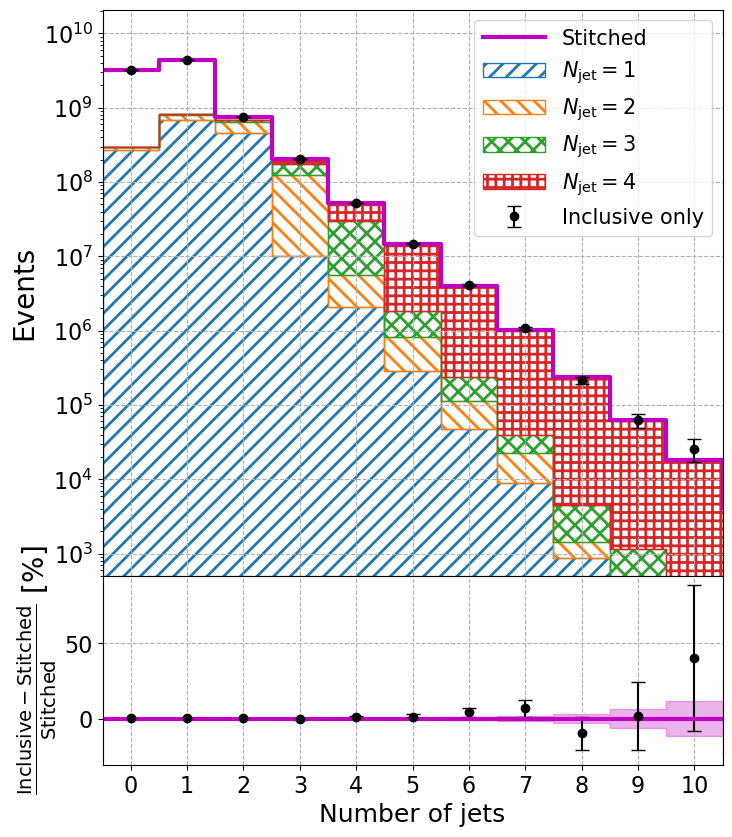

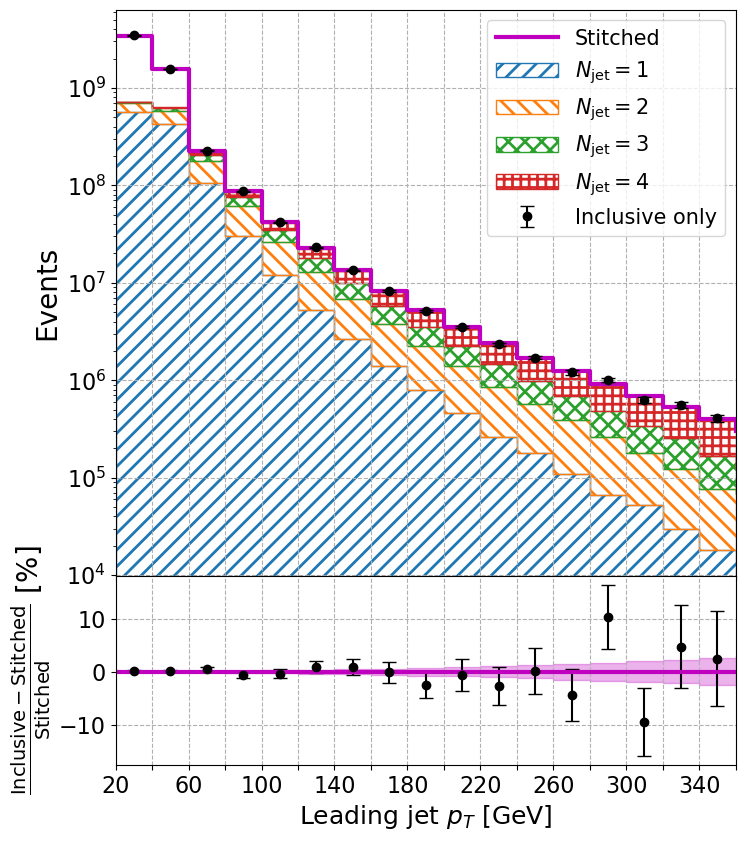

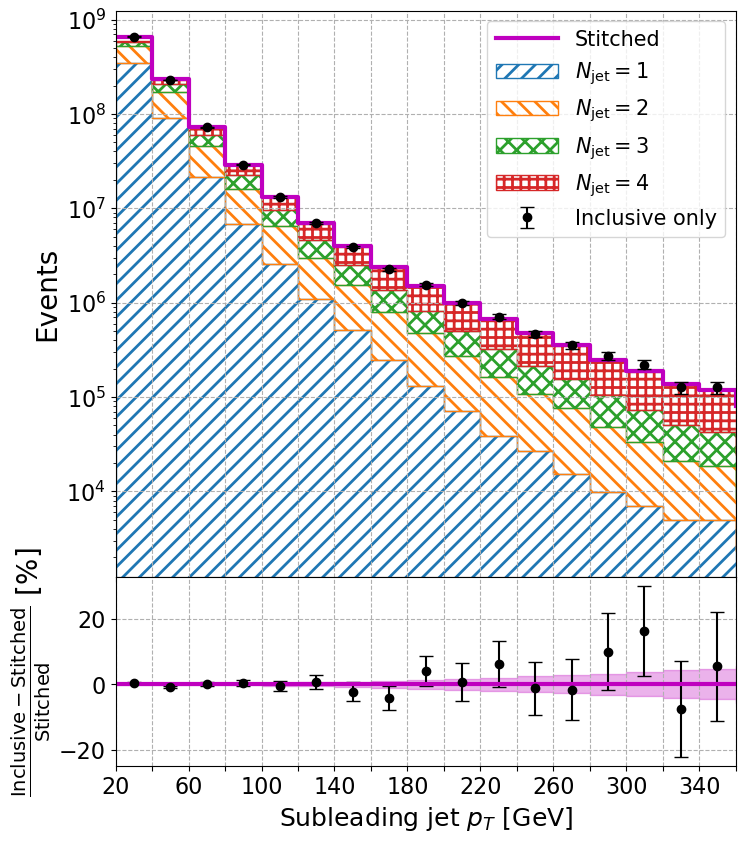

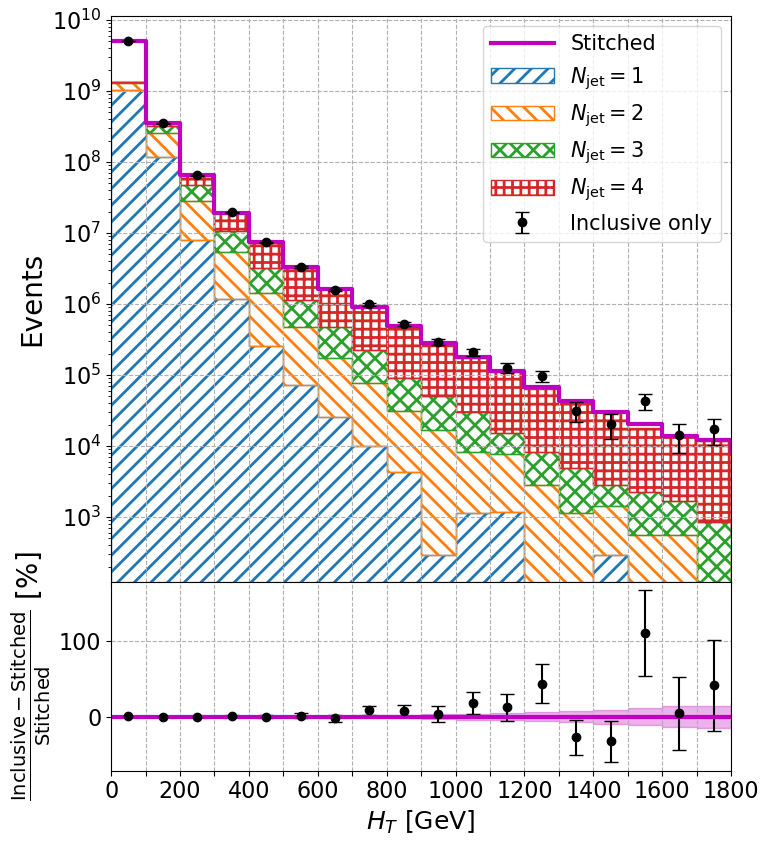

Sample name,Number of events,Cross section [pb]
Inclusive,3.000e+06,6.153e+04
Njet = 1,4.900e+06,1.013e+04
Njet = 2,1.600e+06,3.214e+03
Njet = 3,4.600e+05,9.378e+02
Njet = 4,2.200e+05,4.432e+02
70 < HT < 100,7.000e+05,1.426e+03
100 < HT < 200,6.900e+05,1.412e+03
200 < HT < 400,1.900e+05,3.793e+02
400 < HT < 600,2.600e+04,5.130e+01
600 < HT < 800,6.200e+03,1.263e+01


PS region,Weight
"0 <= LHE_Njets < 1, 0 <= LHE_HT < 70",2870
"0 <= LHE_Njets < 1, 70 <= LHE_HT < 100",0
"0 <= LHE_Njets < 1, 100 <= LHE_HT < 200",0
"0 <= LHE_Njets < 1, 200 <= LHE_HT < 400",0
"0 <= LHE_Njets < 1, 400 <= LHE_HT < 600",0
"0 <= LHE_Njets < 1, 600 <= LHE_HT < 800",0
"0 <= LHE_Njets < 1, 800 <= LHE_HT < 1200",0
"0 <= LHE_Njets < 1, 1200 <= LHE_HT < 2500",0
"0 <= LHE_Njets < 1, 2500 <= LHE_HT < 13000",0
"0 <= LHE_Njets < 1, 13000 <= LHE_HT < 100000",0


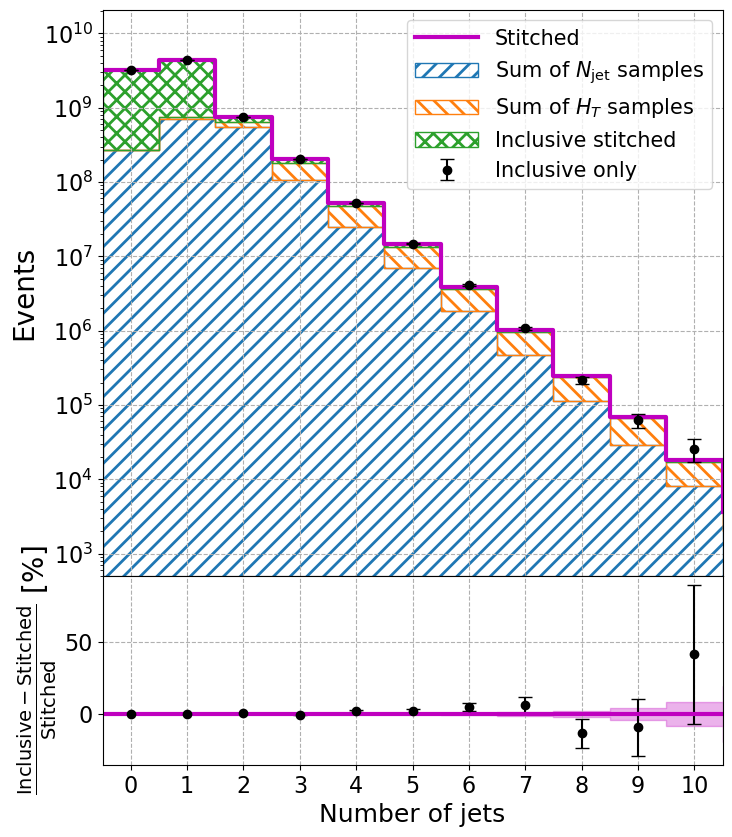

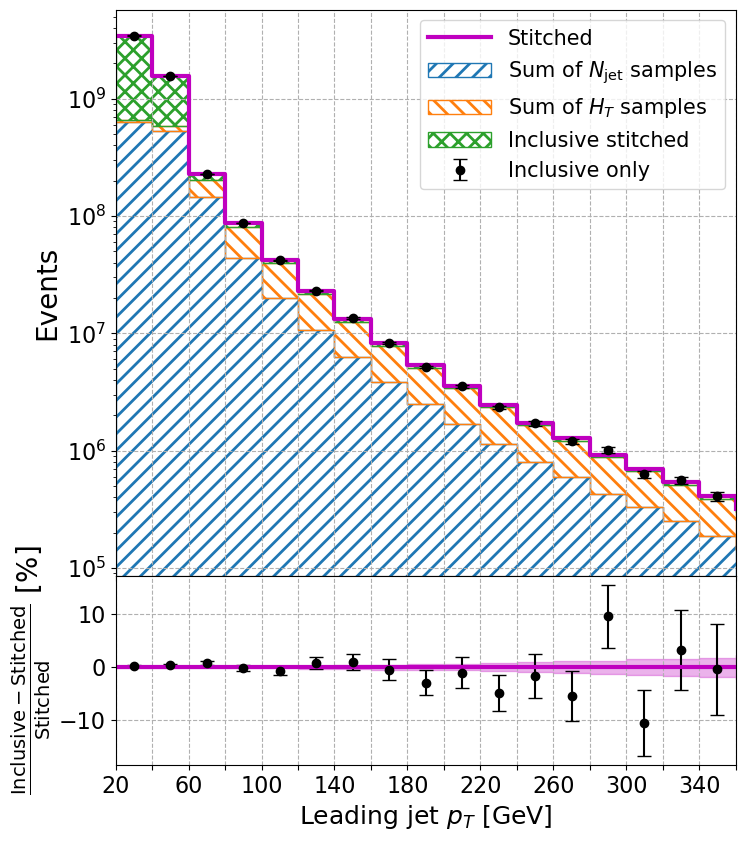

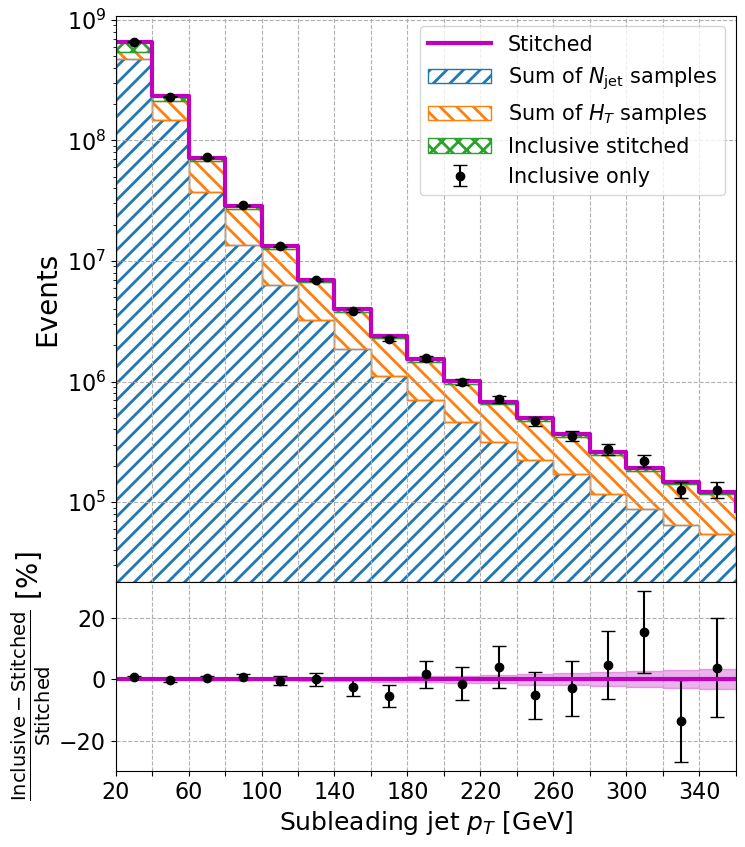

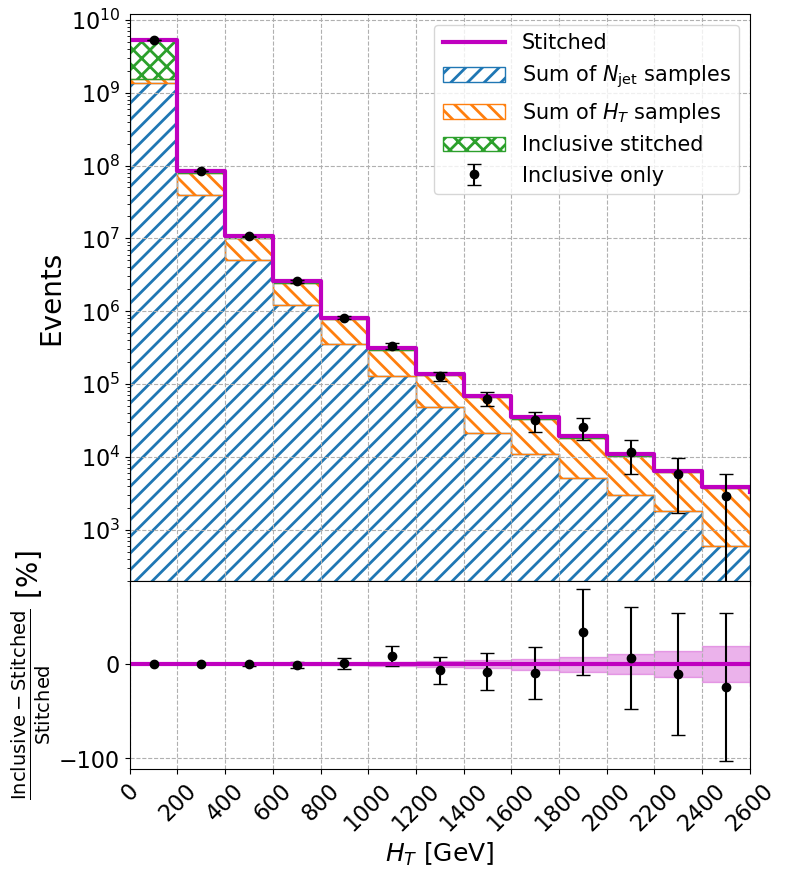

In [3]:
input_dir = 'inputs' # download from: https://cernbox.cern.ch/index.php/s/xQ6cvkk4Ja9tYxn
choices = {
  'WJets_Njet' : False,
  'WJets' : True,
}
for choice in choices:
  stitch(choice, input_dir, choices[choice])